In [1]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
import tqdm
import os
from numpy import ma
import time
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import datetime
from datetime import tzinfo

def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def dereference(sel, ref, data=None, region=None, mask=None, ref_direction=(0,1), indices_only=False, as_masked=True):
    '''
        Load ``data`` referred to by ``ref`` that corresponds to the desired
        positions specified in ``sel``.

        :param sel: iterable of indices, an index, or a ``slice`` to match against ``ref[:,ref_direction[0]]``. Return value will have same first dimension as ``sel``, e.g. ``dereference(slice(100), ref, data).shape[0] == 100``

        :param ref: a shape (N,2) ``h5py.Dataset`` or array of pairs of indices linking ``sel`` and ``data``

        :param data: a ``h5py.Dataset`` or array to load dereferenced data from, can be omitted if ``indices_only==True``

        :param region: a 1D ``h5py.Dataset`` or array with a structured array type of [('start','i8'), ('stop','i8')]; 'start' defines the earliest index within the ``ref`` dataset for each value in ``sel``, and 'stop' defines the last index + 1 within the ``ref`` dataset (optional). If a ``h5py.Dataset`` is used, the ``sel`` spec will be used to load data from the dataset (i.e. ``region[sel]``), otherwise ``len(sel) == len(region)`` and a 1:1 correspondence is assumed

        :param mask: mask off specific items in selection (boolean, True == don't dereference selection), len(mask) == len(np.r_[sel])

        :param ref_direction: defines how to interpret second dimension of ``ref``. ``ref[:,ref_direction[0]]`` are matched against items in ``sel``, and ``ref[:,ref_direction[1]]`` are indices into the ``data`` array (``default=(0,1)``). So for a simple example: ``dereference([0,1,2], [[1,0], [2,1]], ['A','B','C','D'], ref_direction=(0,1))`` returns an array equivalent to ``[[],['A'],['B']]`` and ``dereference([0,1,2], [[1,0], [2,1]], ['A','B','C','D'], ref_direction=(1,0))`` returns an array equivalent to ``[['B'],['C'],[]]``

        :param indices_only: if ``True``, only returns the indices into ``data``, does not fetch data from ``data``

        :returns: ``numpy`` masked array (or if ``as_masked=False`` a ``list``) of length equivalent to ``sel``
    '''

    # set up selection
    sel_mask = mask
    sel_idcs = np.r_[sel][~sel_mask] if sel_mask is not None else np.r_[sel]
    n_elem = len(sel_idcs) if sel_mask is None else len(sel_mask)

    return_dtype = data.dtype if not indices_only else ref.dtype

    if not len(sel_idcs) and n_elem:
        # special case for if there is nothing selected in the mask
        if as_masked:
            return ma.array(np.empty((n_elem,1), dtype=return_dtype), mask=True, shrink=False)
        else:
            return [np.empty(0, data.dtype) for _ in range(n_elem)]
    elif not len(sel_idcs):
        if as_masked:
            return ma.array(np.empty((0,1), dtype=return_dtype), mask=True, shrink=False)
        else:
            return []

    # load fast region lookup
    if region is not None:
        if isinstance(region, h5py.Dataset):
            if isinstance(sel, slice):
                region = region[sel] # load parent reference region information
            else:
                region_offset = np.min(sel_idcs)
                region_sel = slice(region_offset, int(np.max(sel_idcs)+1))
                region = region[region_sel][sel_idcs - region_offset]
        else:
            region = region[sel_idcs]

    # load relevant references
    region_valid = region['start'] != region['stop'] if region is not None else None
    if not region is None and np.count_nonzero(region_valid) == 0:
        # special case for if there are no valid references
        if as_masked:
            return ma.array(np.empty((n_elem,1), dtype=return_dtype), mask=True)
        else:
            return [np.empty(0, return_dtype) for _ in range(n_elem)]
    ref_offset = np.min(region[region_valid]['start']) if region is not None else 0
    ref_sel = slice(ref_offset, int(np.max(region[region_valid]['stop']))) if region is not None else slice(ref_offset,len(ref))
    ref = ref[ref_sel]

    # if no valid references, return
    if len(ref) == 0:
        if as_masked:
            return ma.array(np.empty((n_elem,1), dtype=return_dtype), mask=True)
        else:
            return [np.empty(0, return_dtype) for _ in range(n_elem)]

    # load relevant data
    dset_offset = np.min(ref[:,ref_direction[1]])
    dset_sel = slice(dset_offset, int(np.max(ref[:,ref_direction[1]])+1))
    dset = data[dset_sel] if not indices_only else None # load child dataset region

    # create a region array, if one was not given
    if region is None:
        region = np.zeros(len(sel_idcs), dtype=ref_region_dtype)
        region['start'] = ref_sel.start
        region['stop'] = ref_sel.stop

    if not as_masked:
        # dump into list using subregion masks
        if indices_only:
            indices = [
                    ref[st:sp,ref_direction[1]][ (ref[st:sp,ref_direction[0]] == i) ]
                    for i,st,sp in zip(sel_idcs, region['start']-ref_offset, region['stop']-ref_offset)
                ]
            return indices
        else:
            data = [
                    dset[ref[st:sp,ref_direction[1]][ (ref[st:sp,ref_direction[0]] == i) ] - dset_offset]
                    for i,st,sp in zip(sel_idcs, region['start']-ref_offset, region['stop']-ref_offset)
                ]
            return data


    # the rest of this is index manipulation to convert from sel -> ref -> data
    # first using only the unique references and then casting it back into the
    # original selection

    # first get mapping from unique selection back into the selection
    uniq_sel, uniq_inv = np.unique(sel_idcs, return_inverse=True)

    # only use references that are relevant to the selection
    ref_mask = np.isin(ref[:,ref_direction[0]], uniq_sel)
    if not np.any(ref_mask):
        # special case if no valid references for selection
        return ma.array(np.empty((n_elem,1), dtype=return_dtype), mask=True, shrink=False)

    # get the number of references per parent and rearrange so that references are in ordered by parent
    uniq, counts = np.unique(ref[ref_mask,ref_direction[0]], return_counts=True)
    reordering = np.argsort(uniq)
    uniq, counts = uniq[reordering], counts[reordering]
    max_counts = np.max(counts)

    # now, we'll fill a subarray consisting of unique elements that were requested (shape: (len(uniq_sel), max_counts) )
    # get a mapping from the unique selection into the unique reference parents
    _,uniq_sel_idcs,uniq2uniq_sel_idcs = np.intersect1d(uniq_sel, uniq, assume_unique=False, return_indices=True)

    # set up subarrays for unique selection
    shape = (len(uniq_sel), max_counts)
    condensed_data = np.zeros(shape, dtype=return_dtype)
    condensed_mask = np.zeros(shape, dtype=bool)

    # block off and prepare slots for unique selection
    condensed_mask[uniq_sel_idcs] = np.arange(condensed_data.shape[1]).reshape(1,-1) < counts[uniq2uniq_sel_idcs].reshape(-1,1)
    view_dtype = np.dtype([('ref0',ref.dtype),('ref1',ref.dtype)])
    sort_ref = np.argsort(ref[ref_mask].view(view_dtype), axis=0,
        order=[view_dtype.names[ref_direction[0]], view_dtype.names[ref_direction[1]]]
        ) # arrange by parent (then by child)
    # and fill slots
    if indices_only:
        np.place(condensed_data, mask=condensed_mask, vals=ref[ref_mask,ref_direction[1]][sort_ref])
    else:
        np.place(condensed_data, mask=condensed_mask, vals=dset[ref[ref_mask,ref_direction[1]][sort_ref] - dset_offset])

    # then cast unique selections into full set of elements that were requested (shape: (len(sel), max_counts) )
    mask = np.zeros((len(sel_mask), max_counts), dtype=bool) if sel_mask is not None \
        else condensed_mask[uniq_inv]
    data = np.zeros((len(sel_mask), max_counts), dtype=condensed_data.dtype) if sel_mask is not None \
        else condensed_data[uniq_inv]
    if sel_mask is not None:
        mask[~sel_mask] = condensed_mask[uniq_inv]
        data[~sel_mask] = condensed_data[uniq_inv]
    return ma.array(data, mask=~mask, shrink=False)

def dereference_chain(sel, refs, data=None, regions=None, mask=None, ref_directions=None, indices_only=False):
    '''
        Load a "chain" of references. Allows traversal of multiple layers of references,
        e.g. for three datasets ``A``, ``B``, and ``C`` linked ``A->B->C``. One
        can use a selection in ``A`` and load the ``C`` data associated with it.

        Example usage::

            sel = slice(0,100)
            refs = [f['A/ref/B/ref'], f['C/ref/B/ref']]
            ref_dirs = [(0,1), (1,0)]
            data = f['C/data']
            regions = [f['A/ref/B/ref_region'], f['B/ref/C/ref_region']]
            mask = np.r_[sel] > 50

            c_data = dereference_chain(sel, refs, data, regions=regions, mask=mask, ref_directions=ref_dirs)
            c_data.shape # (100, max_a2b_assoc, max_b2c_assoc)

        :param sel: iterable of indices, a slice, or an integer, see ``sel`` argument in ``dereference``

        :param refs: a list of reference datasets to load, in order, see ``ref`` argument in ``dereference``

        :param data: a dataset to load dereferenced data from, optional if ``indices_only=True``

        :param regions: lookup table into ``refs`` for each selection, see ``region`` argument in ``dereference``

        :param mask: a boolean mask into the first selection, true will not load the entry

        :param ref_directions: intepretation of reference datasets, see ``ref_direction`` argument in ``dereference``

        :param indices_only: flag to skip loading the data and instead just return indices into the final dataset

    '''
    sel = np.r_[sel]
    mask = np.zeros_like(sel, dtype=bool) | (mask if mask is not None else False)
    sel = ma.array(sel, mask=mask, shrink=False)
    shape = (len(sel),)
    dref = None

    nsteps = len(refs)
    for i in range(nsteps):
        dset = data if i == nsteps-1 else None
        ref = refs[i]
        ref_dir = ref_directions[i] if ref_directions else (0,1) # default to (0,1)
        reg = regions[i] if regions else None

        dref = dereference(sel.data.ravel(), ref,
            data=dset, region=reg,
            mask=mask.ravel(), ref_direction=ref_dir,
            indices_only=True if i != nsteps-1 else indices_only)
        shape += dref.shape[-1:]

        mask = np.expand_dims(mask, axis=-1) | \
            (rfn.structured_to_unstructured(dref.mask).any(axis=-1).reshape(shape) \
            if dref.mask.dtype.kind == 'V' else dref.mask.reshape(shape))
        dref = ma.array(dref.data.reshape(shape), mask=mask, shrink=False)

        if i != nsteps-1:
            sel = dref

    return dref

bounds =[[-63.93099976, 63.93099976], [-62.07600145, 62.07600145], [-64.53799944,  64.53799944]]

def plot_geo(ax, bounds):
    
    ax.set_xlim(bounds[0][0]-5, bounds[0][1]+5)
    ax.set_ylim(bounds[1][0]-5, bounds[1][1]+5)
    ax.set_zlim(bounds[2][0]-5, bounds[2][1]+5)
    
    ax.set_xlabel('z [cm]', fontsize=14, weight='bold')
    ax.set_ylabel('y [cm]', fontsize=14, weight='bold')
    ax.set_zlabel('x [cm]', fontsize=14, weight='bold')
    
    # top
    x = [bounds[0][0],bounds[0][1],bounds[0][1],bounds[0][0]]
    y = [bounds[1][0],bounds[1][0],bounds[1][1],bounds[1][1]]
    z = [bounds[2][1],bounds[2][1],bounds[2][1],bounds[2][1]]
    verts = [list(zip(x,y,z))]
    ax.add_collection3d(Poly3DCollection(verts, alpha=0.08, color='grey'))
    
    # bottom
    x = [bounds[0][0],bounds[0][1],bounds[0][1],bounds[0][0]]
    y = [bounds[1][0],bounds[1][0],bounds[1][1],bounds[1][1]]
    z = [bounds[2][0],bounds[2][0],bounds[2][0],bounds[2][0]]
    verts = [list(zip(x,y,z))]
    ax.add_collection3d(Poly3DCollection(verts, alpha=0.08, color='grey'))
    
    # left
    x = [bounds[0][0],bounds[0][0],bounds[0][0],bounds[0][0]]
    y = [bounds[1][0],bounds[1][0],bounds[1][1],bounds[1][1]]
    z = [bounds[2][1],bounds[2][0],bounds[2][0],bounds[2][1]]
    verts = [list(zip(x,y,z))]
    ax.add_collection3d(Poly3DCollection(verts, alpha=0.08, color='grey'))
    
    # right
    x = [bounds[0][1],bounds[0][1],bounds[0][1],bounds[0][1]]
    y = [bounds[1][0],bounds[1][0],bounds[1][1],bounds[1][1]]
    z = [bounds[2][1],bounds[2][0],bounds[2][0],bounds[2][1]]
    verts = [list(zip(x,y,z))]
    ax.add_collection3d(Poly3DCollection(verts, alpha=0.08, color='grey'))
    
    # front
    x = [bounds[0][0],bounds[0][0],bounds[0][1],bounds[0][1]]
    y = [bounds[1][0],bounds[1][0],bounds[1][0],bounds[1][0]]
    z = [bounds[2][0],bounds[2][1],bounds[2][1],bounds[2][0]]
    verts = [list(zip(x,y,z))]
    ax.add_collection3d(Poly3DCollection(verts, alpha=0.08, color='grey'))
    
    # back
    x = [bounds[0][0],bounds[0][0],bounds[0][1],bounds[0][1]]
    y = [bounds[1][1],bounds[1][1],bounds[1][1],bounds[1][1]]
    z = [bounds[2][0],bounds[2][1],bounds[2][1],bounds[2][0]]
    verts = [list(zip(x,y,z))]
    ax.add_collection3d(Poly3DCollection(verts, alpha=0.08, color='grey'))
    
    
def display(ff, event=None, ignore_no_trigger=False):
    
    if event is None: 
        events= ff['charge/events/data']
        
        if not ignore_no_trigger:
            events=events[ events['n_ext_trigs'] > 0  ]
            
        events= events[events['nhit']>100]['id']
        event=events[0]
        
    events = ff['charge/events/data']
    print(events.dtype)
    events_hits_ref = ff['charge/events/ref/charge/calib_prompt_hits/ref']
    events_trig_ref = ff['charge/events/ref/charge/ext_trigs/ref']
    events_hits_rref = ff['charge/events/ref/charge/calib_prompt_hits/ref_region']
    events_trig_rref = ff['charge/events/ref/charge/ext_trigs/ref_region']
    
    hits=dereference(event, events_hits_ref, ff['charge/calib_prompt_hits/data'], region=events_hits_rref)
    
    mask=hits['Q']>6
    hits=hits[mask]
    trig=dereference(event, events_trig_ref, ff['charge/ext_trigs/data'], region=events_trig_rref)
    
    
    fig=plt.figure(figsize=(8,8))
    ax=fig.add_subplot(projection='3d')
    sc=ax.scatter( hits['z'].flatten(), hits['y'].flatten(), hits['x'].flatten(), c=hits['Q'].flatten(), marker='.', s=0.2, alpha=1 )
    
    if type(event)==int:
        ax.set_title('Event {}\n{}\n{}'.format(event, fname, datetime.datetime.fromtimestamp(events[event]['unix_ts']+120*60)))
    else:
        ax.set_title('Event Collection\n{}'.format(fname))
    plot_geo(ax, bounds)
    #ax.view_init(elev=180, azim=20)
    cbar=plt.colorbar(sc, ax=ax, fraction=0.05)
    cbar.set_label(label='charge [ke-]',weight='bold', fontsize=14, rotation=-90, labelpad=10)
    plt.show()
    
def display_iog(ff, event=None, ignore_no_trigger=False):
    
    hits, packets, trig = get_event_packets(event)
    fig=plt.figure(figsize=(8,8))
    ax=fig.add_subplot(projection='3d')
    
        
    #sc=ax.scatter( hits['z'].flatten(), hits['y'].flatten(), hits['x'].flatten(), c='grey', alpha=0.45, marker='.', s=0.35 )
    
    colors=['red', 'orange', 'gold', 'limegreen', 'teal', 'dodgerblue', 'blueviolet', 'magenta']
    for iog in range(1,9):
        mask = hits['io_group']==iog
    
        sc=ax.scatter( hits['z'][mask].flatten(), hits['y'][mask].flatten(), hits['x'][mask].flatten(), c=colors[iog-1], alpha=1, marker='.', s=0.35, label=str(iog) )

        
    
    if type(event)==int:
        ax.set_title('Event {}\n{}\n{}'.format(event, fname, datetime.datetime.fromtimestamp(events[event]['unix_ts']+120*60)))
    else:
        ax.set_title('Event Collection\n{}'.format(fname))
    plot_geo(ax, bounds)
    #ax.view_init(elev=180, azim=20)
    #cbar=plt.colorbar(sc, ax=ax, fraction=0.05)
    #cbar.set_label(label='charge [ke-]',weight='bold', fontsize=14, rotation=-90, labelpad=10)
    lgnd=ax.legend()
    for handle in lgnd.legend_handles:
        handle.set_sizes([12.0])
    
    plt.show()

In [228]:
def unique_channel_id(d):
    return ((d['io_group'].astype(int)*1000+d['io_channel'].astype(int))*1000 \
            + d['chip_id'].astype(int))*100 + d['channel_id'].astype(int)

def get_event_packets(event):
    events_hits_ref = ff['charge/events/ref/charge/calib_prompt_hits/ref']
    events_trig_ref = ff['charge/events/ref/charge/ext_trigs/ref']
    events_hits_rref = ff['charge/events/ref/charge/calib_prompt_hits/ref_region']
    events_trig_rref = ff['charge/events/ref/charge/ext_trigs/ref_region']
    hits_packets_ref = ff['charge/raw_hits/ref/charge/packets/ref']
    hits_packets_rref = ff['charge/raw_hits/ref/charge/packets/ref_region']
    
    hits=dereference(event, events_hits_ref, ff['charge/calib_prompt_hits/data'], region=events_hits_rref)
    packets = dereference(hits['id'], hits_packets_ref, ff['charge/packets/data'], region=hits_packets_rref)
    trig=dereference(event, events_trig_ref, ff['charge/ext_trigs/data'], region=events_trig_rref)
    
    adjacent_channels =  [2, 3, 4, 5, 6, 8, 9, 11]
    adjacent_channels_diff =  [i-7 for i in adjacent_channels]
    
    hits, packets, trigs = get_event_packets(1156)
    hits=hits.flatten()
    packets=packets.flatten()

    mask7=packets['channel_id']==7
    hits7=hits[mask7]

    packets7=packets[mask7]

    us = unique_channel_id(packets[np.logical_not(mask7)])
    u7 = unique_channel_id(packets7)


    mask=np.zeros(u7.shape)
    for iu, u in enumerate(u7):
        diffs = u-us
        mask[iu] = np.any( np.logical_or(np.logical_or(np.logical_or(np.absolute(diffs)<3 , diffs==-5) , diffs==-4 ), diffs==4 ) ) 
    
    mask_full = hits['Q']>0
    mask_full[mask7] = mask.astype(bool)

    hits=hits[mask_full]
    packets=packets[mask_full]
    
    return hits, packets, trig

In [229]:
ddir = '/global/cfs/projectdirs/dune/www/data/2x2/nearline/flowed_charge/beam/july10_2024/nominal_hv/'
#fname=list(sorted(os.listdir(ddir)))[-32]
fname='packet-0050018-2024_07_11_14_49_19_CDT.FLOW.hdf5'
ff=h5py.File(ddir+fname)
print(fname)

packet-0050018-2024_07_11_14_49_19_CDT.FLOW.hdf5


In [74]:
events= ff['charge/events/data']
evs = events[ (events['nhit']>2000)  & (events['nhit']<20000)  & events['n_ext_trigs']>0]['id'] 

In [230]:
display_iog(ff, int(evs[15]))
print(evs[15])



Error in sys.excepthook:
object address  : 0x7fa9e260b580
object refcount : 1
object type     : 0x55ac6e12b920
object type name: RecursionError
object repr     : 
lost sys.stderr

Original exception was:
object address  : 0x7fa9de0368c0
object refcount : 2
object type     : 0x55ac6e12b920
object type name: RecursionError
object repr     : 
lost sys.stderr


RecursionError: maximum recursion depth exceeded while calling a Python object

(18,)
1.306070221794976


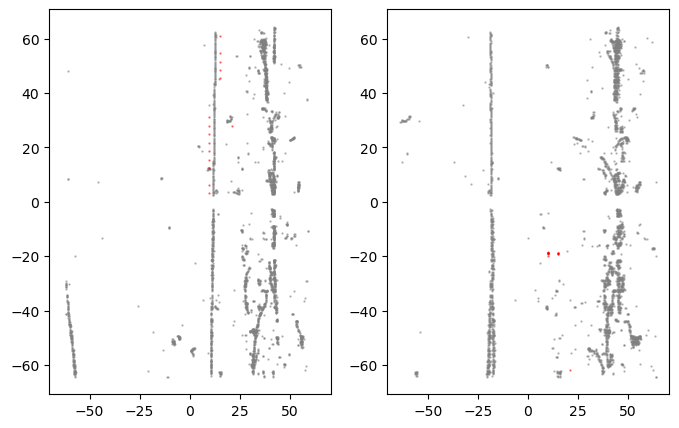

In [175]:
hits, packets, trigs = get_event_packets(1156)
hits=hits.flatten()
packets=packets.flatten()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5), sharey=True)
mask7=packets['channel_id']==7

hits7=hits[mask7]

packets7=packets[mask7]

us = unique_channel_id()



adjacent_channels =  [2, 3, 4, 5, 6, 8, 9, 11]

adj_hits_mask = packets['channel_id'] < 0

for chan in adjacent_channels:
    adj_hits_mask = np.logical_or(packets['channel_id']==chan, adj_hits_mask)
    
adj_hits = hits[adj_hits_mask]

ax1.scatter(hits['y'], hits['z'], color='grey', s=2, marker='.', alpha=0.5)
ax2.scatter(hits['x'], hits['z'], color='grey', s=2, marker='.', alpha=0.5)
ax1.scatter(hits7['y'], hits7['z'], s=2, marker='.', color='red', alpha=0.5)
ax2.scatter(hits7['x'], hits7['z'], s=2, marker='.', color='red', alpha=0.5)

ax1.scatter(adj_hits['y'], adj_hits['z'], s=2, marker='.', color='blue', alpha=0.5)
ax2.scatter(adj_hits['x'], adj_hits['z'], s=2, marker='.', color='blue', alpha=0.5)

In [189]:
packets[mask7][nmask]['dataword']

masked_array(data=[42, 46, 40, 38, 44, 41, 46, 42, 40, 42, 46, 47, 43, 41,
                   40],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False],
       fill_value=63,
            dtype=uint8)

In [184]:
mask

array([False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False])

In [224]:
def get_all_beam_events():
    alltrigs = ff['charge/ext_trigs/data']
    beamtrigs = alltrigs[alltrigs['iogroup']==5]
    beam_events_trig_ids = beamtrigs['id']
    all_events = ff['charge/events/data']
    trigger_events = all_events[all_events['n_ext_trigs']>0]
    beam_events = trigger_events[beam_events_trig_ids]
    return beam_events['id']

array([  15,   22,   53,   56,   75,   81,   84,  134,  141,  146,  157,
        161,  170,  175,  193,  205,  229,  236,  240,  253,  256,  262,
        267,  273,  277,  282,  290,  295,  302,  312,  328,  337,  342,
        352,  367,  373,  379,  385,  391,  402,  408,  441,  465,  469,
        475,  492,  498,  506,  522,  539,  547,  560,  575,  587,  596,
        602,  608,  615,  639,  647,  650,  658,  678,  692,  698,  718,
        755,  757,  761,  766,  789,  798,  806,  822,  827,  832,  836,
        840,  848,  851,  857,  869,  879,  889,  903,  912,  917,  939,
        945,  953,  966,  973,  990,  997, 1004, 1011, 1015, 1036, 1046,
       1055, 1083, 1109, 1118, 1136, 1150, 1156, 1161, 1173, 1182, 1191,
       1193, 1196, 1205, 1216, 1223, 1231, 1234, 1241, 1247, 1251, 1256,
       1262, 1270, 1277, 1286, 1292, 1312, 1321, 1327, 1331, 1380, 1384,
       1395, 1400, 1423, 1429, 1443, 1447, 1456, 1464, 1475, 1488, 1492,
       1500, 1504, 1510, 1529, 1538, 1546, 1554, 15

In [219]:

trig_events = 
['id'][0:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint64)

In [221]:
ff['charge/ext_trigs/data']['id'].shape

(1132,)